# Разведочный анализ данных для проекта

## Паспорт датасета

> 1. Назначение  
Датасет предназначен для разработки и тестирования системы автоматического распознавания и структурирования результатов лабораторных анализов на русскоязычных бланках: извлечение наименований показателей, значений, единиц измерения и референсных диапазонов.

> 2. Состав и формат  
- **Формат:** растровые изображения (JPG/PNG) лабораторных бланков + аннотации в формате COCO (JSON) с рамками (bbox) текстовых областей.  
- **Объём:** 31 изображение.  
- **Разметка:** для каждого изображения указаны bounding box страницы (каждая рамка = зона текста).  
- **Язык:** русский (основной текст бланков).  
- **Качество сбора:** фотографии сделаны на смартфон, на разных поверхностях, с разным освещением и углами.

> 3. Источники и сбор  
- Листы результатов анализов, сняты в условиях реального использования (разные поверхности, освещение).   
- Аннотирование выполнено вручную с проверкой корректности.

> 4. Аннотации  
- Формат: COCO JSON.  
  - Раздел `images`: id, file_name, width, height.  
  - Раздел `annotations`: id, image_id, bbox [x, y, width, height], category_id.  
  - Категория: «текстовое поле».  
- Каждое изображение имеет один лист.

> 5. Особенности и ограничения  
- **Особенности:** разнообразие условий съёмки (наклон, тень, блик) позволяет тестировать устойчивость моделей.  
- **Ограничения:** небольшой объём (31 изображение) - требует дополнения или аугментации для обучения моделей; различные шаблоны бланков - может усложнять обобщение; некоторые изображения с плохим качеством (низкая резкость, сильные тени или блики) - возможны проблемы при OCR.

> Изображения датасета

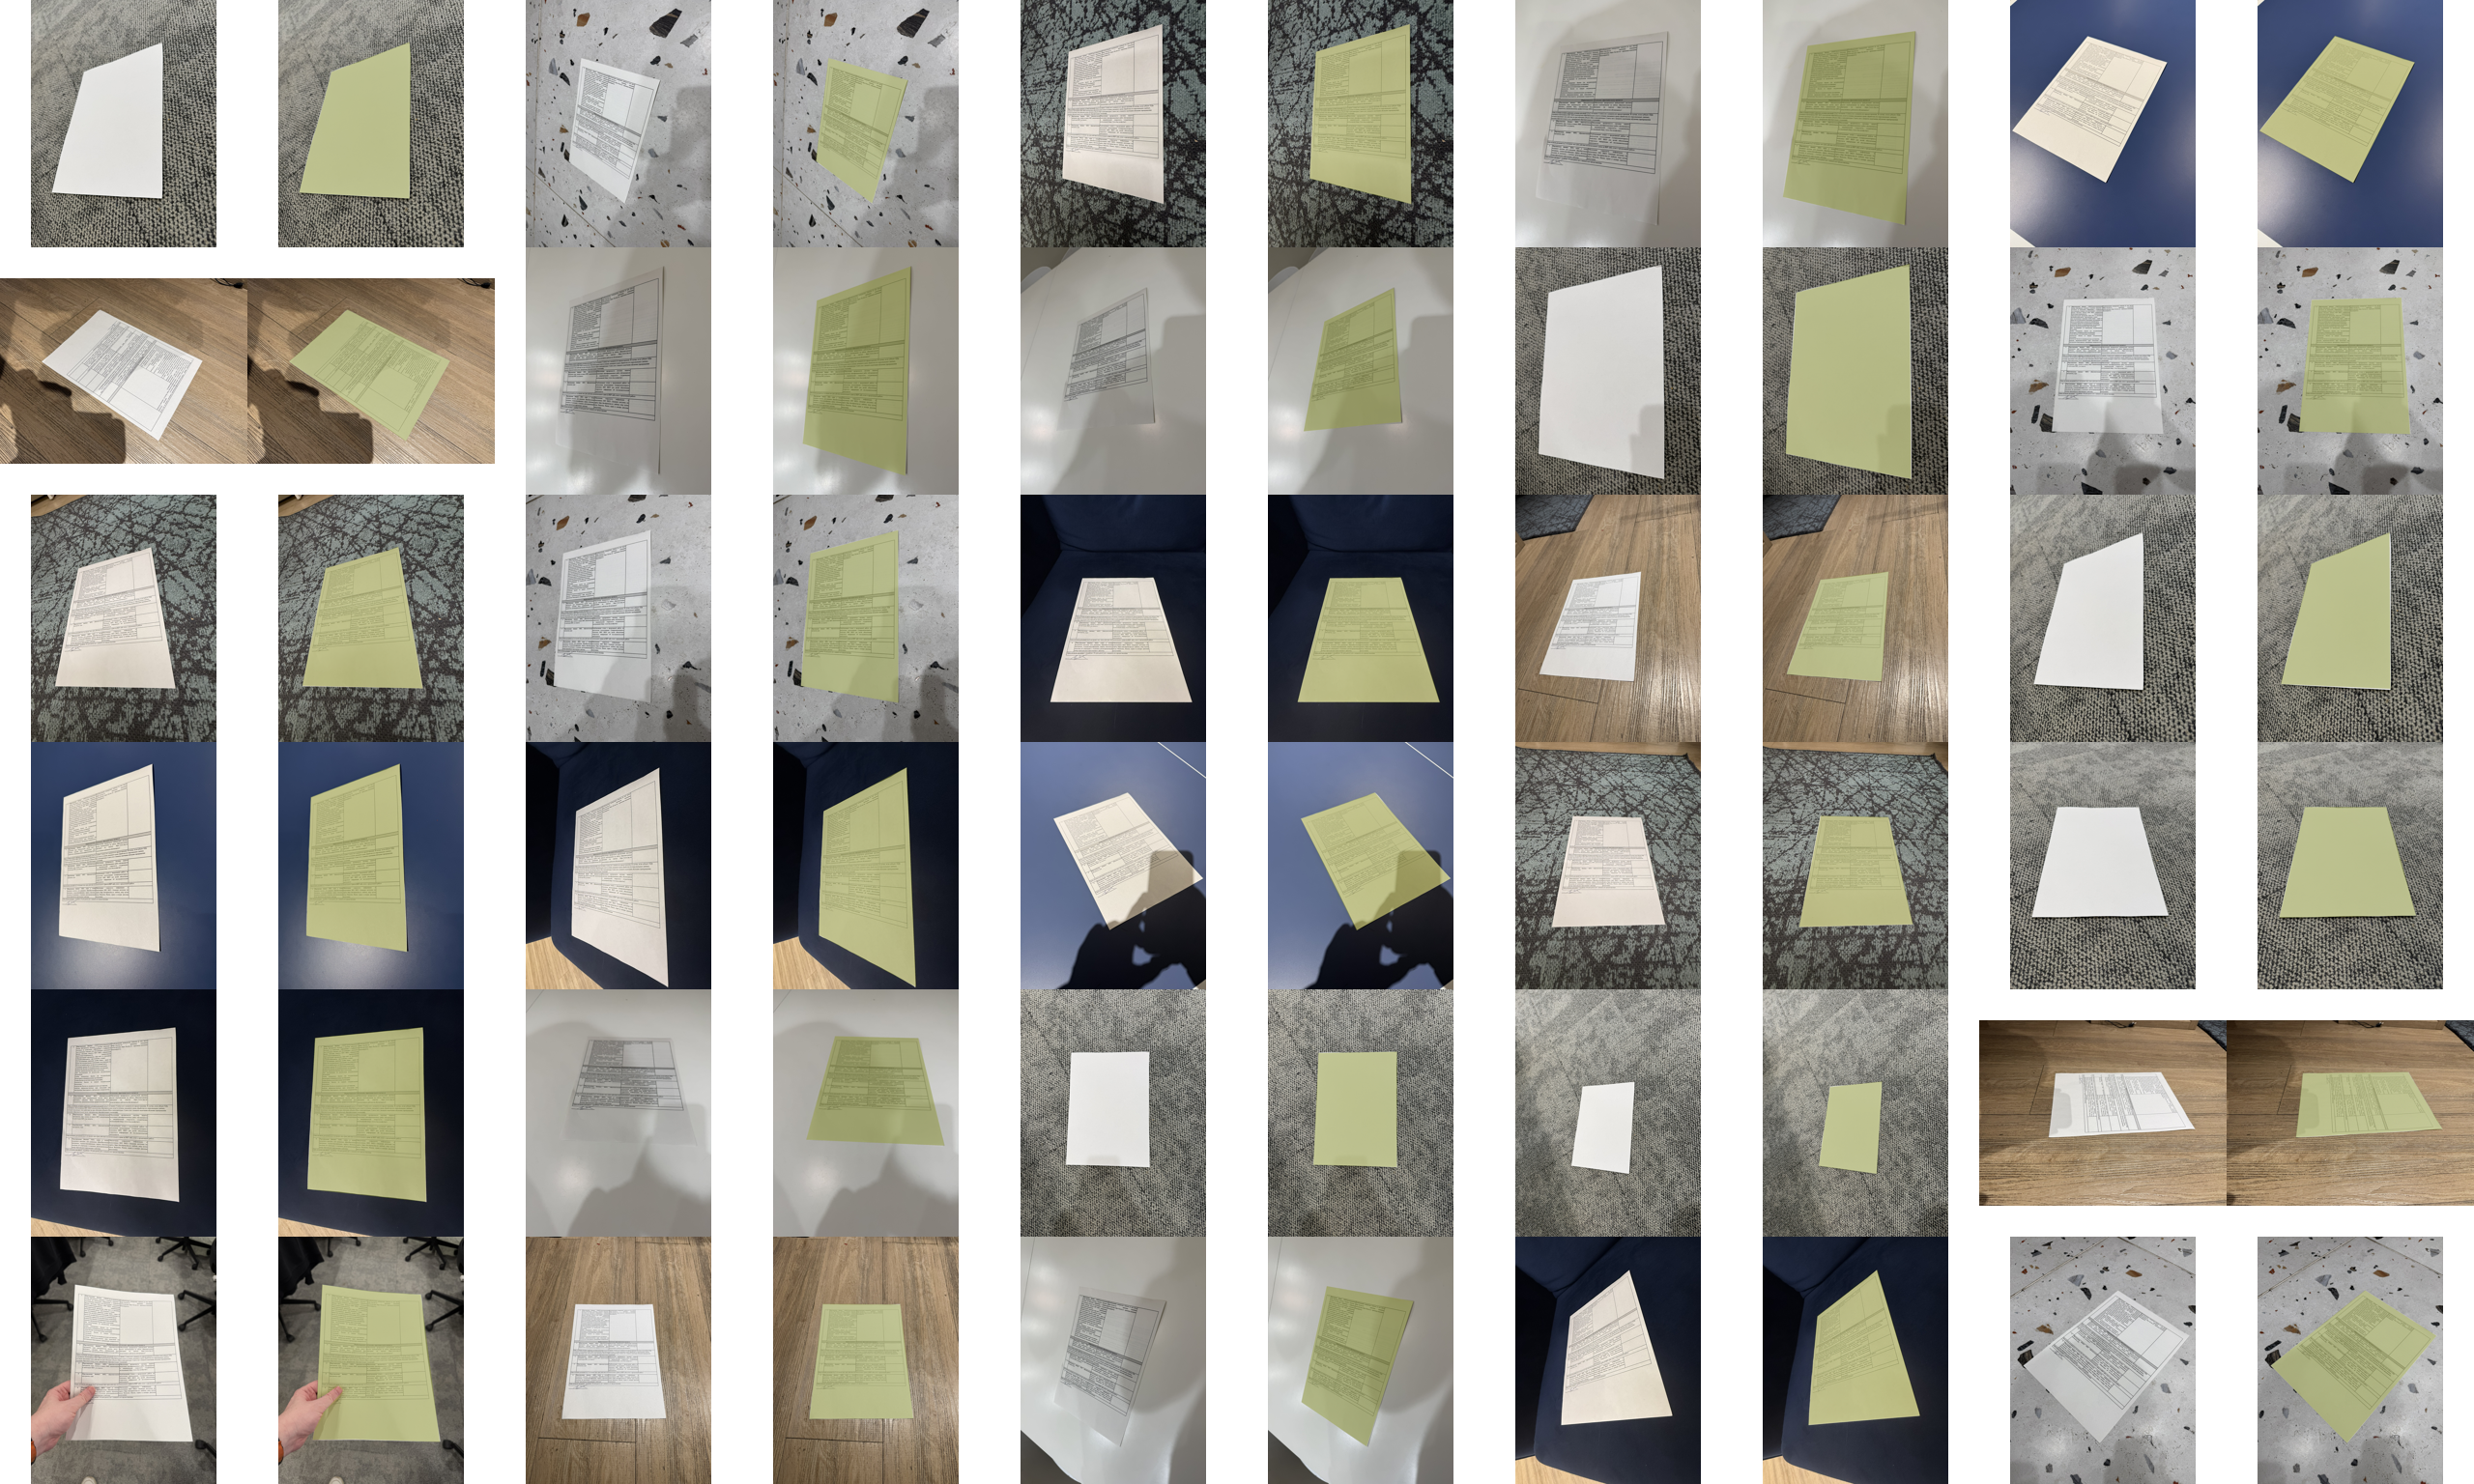

Основная цель датасета исследование детектирования и распознавания текста при различных условиях

## Детекция текста

### Возможные модели  
* **EAST (А Efficient and Accurate Scene Text Detector)** - полностью сверточная сеть, выдаёт рамки текста (в том числе повернутые) за один проход; показывает F-score ~0.78 на ICDAR 2015. 
* **CRAFT (Character‑Region Awareness for Text detection)** - детектор, который анализирует регионы символов и их связи (affinity), хорошо справляется с наклоненным или деформированным текстом. 
* **DETR‑подобные методы (трансформеры для детекции текста)** - современные архитектуры, применяющие трансформеры для прямой детекции произвольных форм текста (например, curved) без множества эвристик. 

### Сравнительная таблица

| Модель            | Преимущества                                              | Ограничения                                               | Когда использовать                                  |
|-------------------|-----------------------------------------------------------|------------------------------------------------------------|-----------------------------------------------------|
| **EAST**          | Быстрая, простая интеграция (например, через OpenCV)      | Может хуже распознавать мелкий, сильно наклонённый или деформированный текст  | Когда изображения относительно «чистые» и прямые    |
| **CRAFT**         | Высокая точность, особенно при наклонах, деформациях     | Более тяжёлая модель, больше вычислений                    | Когда есть много наклонов/ближков/сложных таблиц   |
| **DETR-типы**     | Универсальность, поддержка произвольных форм текста       | Новые, требуют больше данных/настройки                      | Когда требуется «выровнять» всё: разные шаблоны, сильно искривлённый текст |

### Рекомендации для нашего проекта  
Наши лабораторные бланки: печатный текст, таблицы, русскоязычный, фото с разными углами и освещением.  
- Начать с использования EAST в качестве базового варианта: относительно лёгкий и быстрый способ выявления текстовых зон.  
- Если по результатам анализа EDA окажется, что часть изображений имеет значительные наклоны, тени, деформации - протестировать CRAFT.  
- Если появятся случаи весьма нестандартных бланков (например, сильно искажен шаблон или текст идёт под очень большим углом) - зарезервировать трансформер-метод (DETR-подобный) как резервный вариант.




## Распознавание текста (OCR)

### Возможные библиотеки  
* **Tesseract** - классический OCR-движок с поддержкой русского языка, хорошо работает на чётких изображениях с печатным текстом. 
* **PaddleOCR** - современный фреймворк на основе глубоких нейронных сетей, ориентирован на многоязычные документы и сложные макеты. 
* **TrOCR** - трансформер-модель «изображение → текст», обеспечивает высокий уровень точности, особенно на сложных или рукописных данных. 

### Сравнительная таблица

| OCR-движок  | Преимущества                                  | Ограничения                                      | Когда использовать                               |
|------------|-----------------------------------------------|-------------------------------------------------|--------------------------------------------------|
| **Tesseract** | Лёгкая установка, поддержка русского, хорош на простых чётких листах | Требует отличного качества изображения; хуже работает с наклоном/бликами | Начальный этап, хорошие фото                     |
| **PaddleOCR**| Высокая точность на табличных/сложных макетах, устойчив к искажениям | Более ресурсоёмкий, настройка сложнее            | При наличии фоток с наклоном, бликами, таблицами |
| **TrOCR**   | Современная архитектура, хорошо для сложных текстов | Требует GPU/ресурсов, может быть избыточен      | Если обычные методы не справляются, рукопись    |

### План   
Для нашего проекта - предлагается следующая стратегия:
1. Использовать **Tesseract** как базовый вариант (baseline).  
2. Провести эксперимент: сравнить **Tesseract** vs **PaddleOCR** на подвыборке изображений с разными условиями (освещение, наклон).  
3. Если окажется много промахов (например, на фото с наклоном или бликом) — включить **TrOCR** как вариант для «трудных» изображений.  
4. Возможно реализовать гибрид: простой снимок → Tesseract, сложный → PaddleOCR/TrOCR.

## Вывод по EDA

В ходе разведочного анализа нашего набора данных - 31 изображения лабораторных бланков с аннотацией листов бумаги (формат COCO) - выявлены следующие ключевые моменты:

### Что удалось выяснить
- Все изображения доступны и размечены на уровне листа: каждая фотография содержит один бланк, и структура данных (папка с изображениями + JSON-аннотация) приведена в порядок.
- Разрешения изображений в большинстве случаев достаточны для распознавания текста: большинство фото имеют хорошую читаемость печатного текста.
- На бланках чётко видны таблицы с результатами, названия анализов, значения и единицы - значит, задача извлечения ключевых полей (*анализ*, *значение*, *единица*) реализуема.

### Какие проблемы обнаружены
- Хотя листы размечены, **не размечены текстовые зоны** (bbox отдельных строк/полей): сейчас аннотация охватывает весь лист, но нужно выделить зоны с текстом (названия анализов, результаты, единицы, диапазоны). Без этого распознавание и последующий парсинг будут менее точными.
- У части фотографий имеются нежелательные условия съёмки: наклон листа (перспектива), тени, блики, фон стола или руки в кадре - всё это может снижать точность OCR.
- Выявлены несколько изображений с пониженной резкостью или низким контрастом, что также может ухудшить качество извлекаемого текста.
- Различия в ориентации изображений (портретная vs альбомная) и в ракурсе означают, что потребуется единообразная предобработка (выравнивание, поворот, коррекция перспективы).

### Что требуется сделать дальше
- **Разметить текстовые зоны** внутри каждого изображения: вручную или полуавтоматически выделить bounding box для каждой значимой текстовой строки или поля - название анализа, значение, единицу, диапазон нормы. Это даст возможность точной целевой обработке и парсингу.
- Настроить предобработку изображений: выравнивание ориентации, устранение наклона, обрезка лишнего фона, коррекция яркости/контраста и резкости.
- Провести тестовое сравнение OCR-движков (как было запланировано) на подготовленной/предобработанной выборке, и зафиксировать baseline метрики.
- На основе результатов OCR и разметки текстовых зон скорректировать пайплайн - возможно, дополнить аугментации (повороты, блики, шум) и расширить набор данных с новыми бланками.

> **Итог:** Набор данных имеет прочную основу. Однако, чтобы перейти к эффективной автоматизации распознавания анализов, необходимо дополнительно уточнить разметку текстовых элементов и провести подготовку изображений. После этого можно с хорошим основанием переходить к этапу OCR и извлечения структурированной информации.

